# Linear Regression-ish Pytorch

In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA,KernelPCA

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


In [14]:
n_z = 10
n_data = 20000
n_batch = 128
n_linear=n_z+1
#n_linear = torch.combinations(torch.arange(n_z+1), with_replacement=False).shape[0]

In [3]:
allStar =  load("allStar_training_clean")
dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)

In [4]:
#spectra = torch.tensor(dataset.dataset["aspcap_interpolated"])
spectra = torch.tensor(dataset[0:20000][0])

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [5]:
z = torch.randn(spectra.shape[0],n_z)
z.requires_grad=True

In [6]:
class LinearRegression(torch.nn.Module):
    def __init__(self,n_z,n_spectra):
        super(LinearRegression, self).__init__()
        self.fc = torch.nn.Linear(n_z, n_spectra)

    def forward(self, x):
        return self.fc(x)

In [15]:
linear = LinearRegression(n_linear,spectra.shape[1]).to(device)

In [16]:
loss = torch.nn.L1Loss()

In [17]:
def expand(tensor):
    """returns polynomialfeatures of order 2 of z"""
    indexes = torch.combinations(torch.arange(tensor.shape[1]), with_replacement=False).to(device)
    left = torch.index_select(tensor, 1, indexes[:,0])
    right = torch.index_select(tensor, 1, indexes[:,1])
    return left*right

In [18]:
loader = torch.utils.data.DataLoader(torch.arange(len(z)),shuffle=True, batch_size=n_batch)

In [19]:
optimizer = torch.optim.Adam(linear.parameters(), lr=0.0001)
optimizer_z = torch.optim.Adam([z], lr=0.0001)

In [ ]:
n = torch.randn(z.shape)*0.001
n[0]

In [ ]:
z

In [ ]:
z

In [32]:
for i in range(10000):
    for idxs in loader:
        spec = spectra[idxs].to(device)
        z_current = z[idxs].to(device)
        ones = torch.ones(len(z_current),1).to(device)
        z_ones = torch.cat((z_current,ones),dim=1)
        #z_poly = expand(z_ones)
        #print(z_poly.shape)
        optimizer.zero_grad()
        optimizer_z.zero_grad()
        #spec_pred = linear(z_poly)
        spec_pred = linear(z_ones)
        err = loss(spec_pred,spec)
        err.backward()
        optimizer.step()
        optimizer_z.step()

    print(f"err:{err}")

err:0.006858767010271549
err:0.006519623100757599
err:0.005757647100836039
err:0.006037754938006401
err:0.006385910324752331
err:0.005539524834603071
err:0.00616369117051363
err:0.005881776101887226
err:0.006505459547042847
err:0.006100209429860115
err:0.005587852094322443
err:0.005960412323474884
err:0.005641568452119827
err:0.006035188678652048
err:0.005399653688073158
err:0.005616763141006231
err:0.006246989127248526
err:0.005811748094856739
err:0.005809423979371786
err:0.006430288776755333
err:0.005928353406488895
err:0.006182332057505846
err:0.005199048202484846
err:0.005993281956762075
err:0.0060694050043821335
err:0.006252683233469725
err:0.005966963246464729
err:0.005505925510078669
err:0.006104295141994953
err:0.006016521714627743
err:0.005718551576137543
err:0.00655939569696784
err:0.005728074349462986
err:0.006096747238188982
err:0.006488520186394453
err:0.005946353077888489
err:0.005920396186411381
err:0.0057928054593503475
err:0.005204270128160715
err:0.005463550332933664


err:0.005402679089456797
err:0.005547175649553537
err:0.005567095708101988
err:0.005597378127276897
err:0.005484055727720261
err:0.005272832233458757
err:0.0054809460416436195
err:0.0052611129358410835
err:0.005657761357724667
err:0.0052948398515582085
err:0.005610755179077387
err:0.005429649259895086
err:0.005871353205293417
err:0.005523018538951874
err:0.005841180216521025
err:0.0054151322692632675
err:0.005708728916943073
err:0.005912561900913715
err:0.005568135064095259
err:0.00538396742194891
err:0.005161122884601355
err:0.006144543644040823
err:0.0053128027357161045
err:0.005608635023236275
err:0.005805877968668938
err:0.005511193536221981
err:0.005654205102473497
err:0.005341255106031895
err:0.005490107927471399
err:0.0057676020078361034
err:0.006162615492939949
err:0.00532359816133976
err:0.0055237021297216415
err:0.00551706925034523
err:0.005950065795332193
err:0.005621746182441711
err:0.005663733463734388
err:0.005511799361556768
err:0.005852268077433109
err:0.006145864725112

KeyboardInterrupt: 

In [ ]:
torch.save(linear,"linear_poly")
torch.save(z,"z")

In [23]:
        spec = spectra[idxs].to(device)
        z_current = z[idxs].to(device)
        ones = torch.ones(len(z_current),1).to(device)
        z_ones = torch.cat((z_current,ones),dim=1)
        #z_poly = expand(z_ones)
        #print(z_poly.shape)
        optimizer.zero_grad()
        optimizer_z.zero_grad()
        #spec_pred = linear(z_poly)
        spec_pred = linear(z_ones)

(500, 700)

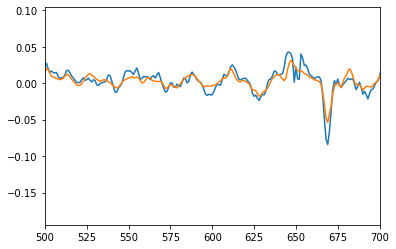

In [25]:
plt.plot(spec[1].cpu().numpy())
plt.plot(spec_pred[1].detach().cpu().numpy())
plt.xlim(500,700)

In [26]:
loss(spec[0],spec_pred[0])

tensor(0.0042, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
z[0]

In [ ]:
z[:5000].shape

# Assessing representation

In [27]:
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5



combined_cut = feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

In [28]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [33]:
z_vec = vector.Vector(z[:n_data][combined_cut[:n_data]].detach().numpy(),order=1,interaction_only=False)

In [34]:
w = vector.LinearTransformation(z_vec,y)


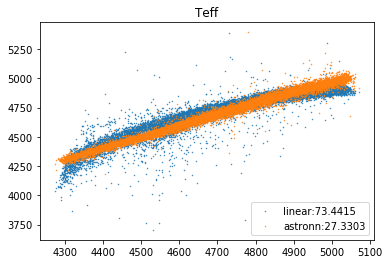

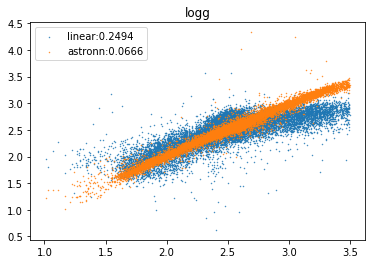

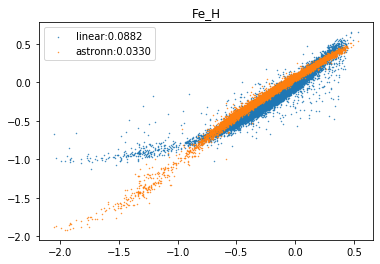

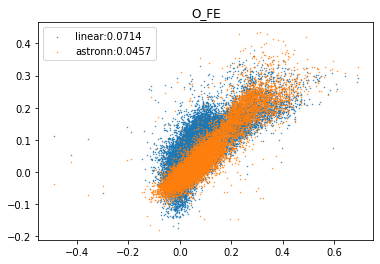

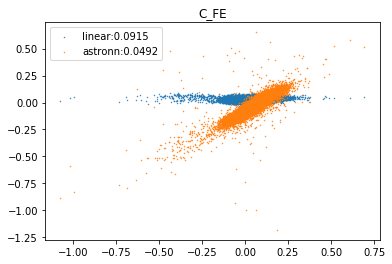

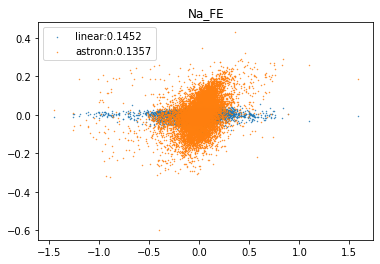

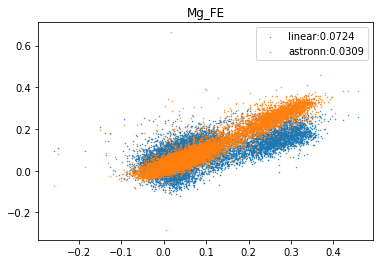

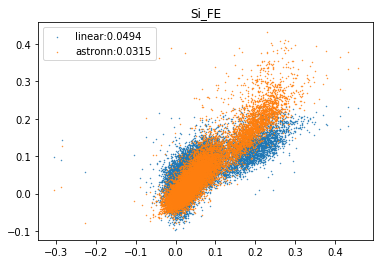

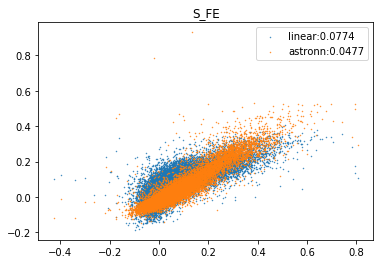

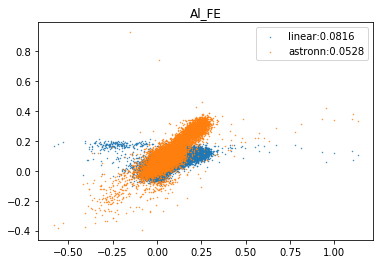

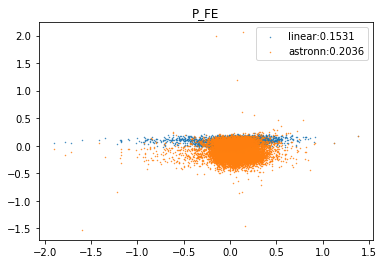

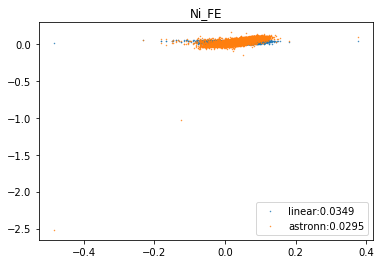

In [31]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z_vec).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z_vec).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

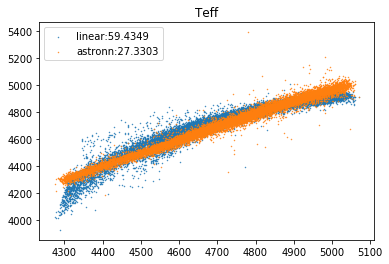

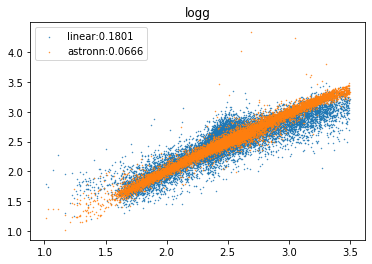

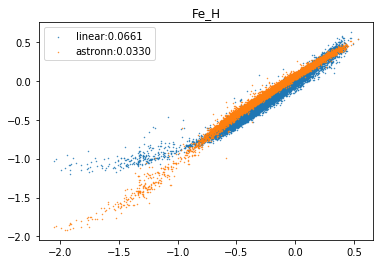

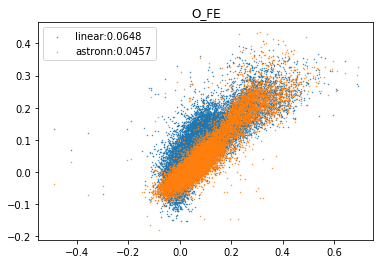

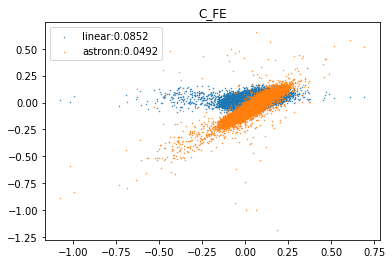

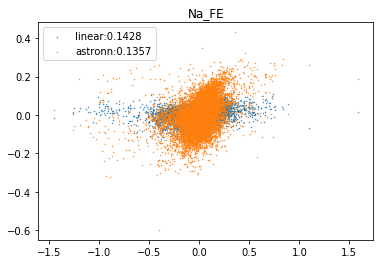

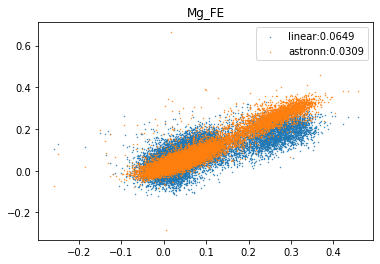

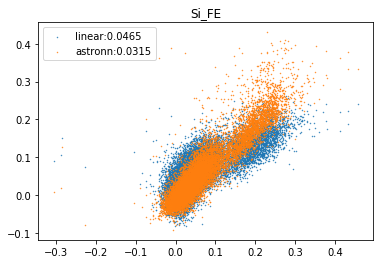

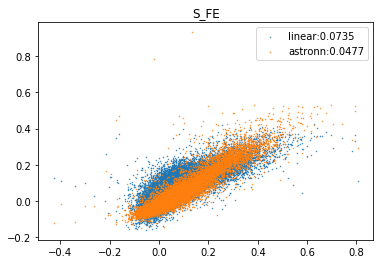

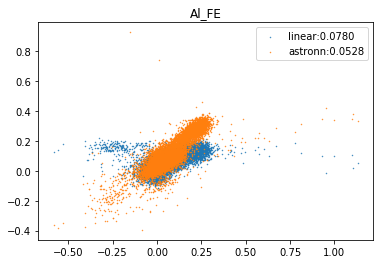

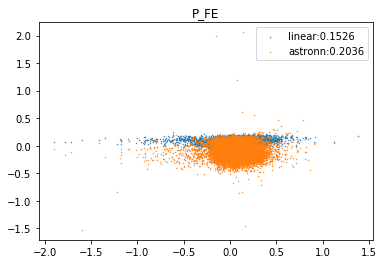

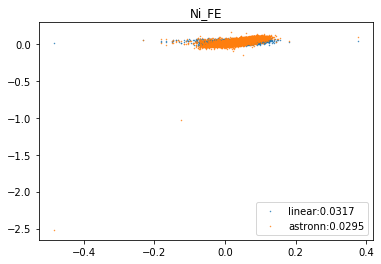

In [35]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z_vec).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z_vec).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

In [ ]:
indexes = torch.combinations(torch.arange(6), with_replacement=True)


In [ ]:
indexes[:,0]

In [ ]:
z_ones[0][indexes]

In [ ]:
torch.combinations(z_ones[0], with_replacement=True)


In [ ]:
left = torch.index_select(z_ones, 1, indexes[:,0])
right = torch.index_select(z_ones, 1, indexes[:,1])

In [ ]:
left.shape

In [ ]:
ones = torch.ones(len(z),1)
z_ones = torch.cat((z,ones),dim=1)

In [ ]:
z_ones.shape

In [ ]:
z_ones.shape[1]

In [ ]:
def expand(z):
    indexes = torch.combinations(torch.arange(z.shape[1]), with_replacement=True)
    left = torch.index_select(z, 1, indexes[:,0])
    right = torch.index_select(z, 1, indexes[:,1])
    return left*right
    

In [ ]:
expand()

In [ ]:
poly.fit_transform(z[0:4].detach().numpy())

In [ ]:
expand(z_ones[0:4])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=False,include_bias=True)
chain = list(poly._combinations(len(z_ones[0])-1,2,interaction_only=True,include_bias=True))

In [ ]:
len(chain)

In [ ]:
chain

In [ ]:
indexes = torch.combinations(torch.arange(z.shape[1]), with_replacement=False)
len(indexes)

In [ ]:
indexes